In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/DIOR-RSVG" "./DIOR-RSVG_ZIP"

In [ ]:
!mkdir ./DIOR-RS-VG/

In [ ]:
!unzip /content/DIOR-RSVG_ZIP/Annotations.zip -d ./DIOR-RS-VG  > /dev/null 2>&1

In [ ]:
!unzip /content/DIOR-RSVG_ZIP/JPEGImages.zip -d ./DIOR-RS-VG > /dev/null 2>&1

In [ ]:
!pip install -r /content/drive/MyDrive/CLIP-VG/requirements.txt > /dev/null 2>&1

In [ ]:
!nvidia-smi

Mon May 13 12:40:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
torch.cuda.empty_cache()

### **Training**

In [ ]:
!CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch \
--nproc_per_node=1 --master_port 28887 --use_env /content/drive/MyDrive/CLIP-VG/train_clip_vg.py \
--num_workers 2 --epochs 110 --batch_size 64 --lr 0.00005  --lr_scheduler cosine \
--aug_crop --aug_scale --aug_translate --imsize 224 --max_query_len 77 \
--dataset dior_rs  \
--vl_nheads 16 \
--data_root /content/ \
--split_root /content/drive/MyDrive/unsup_multi_source_msa  \
--resume /content/drive/MyDrive/test/dior_rs/checkpoint.pth \
--output_dir /content/drive/MyDrive/test/dior_rs ;

/usr/local/lib/python3.10/dist-packages/torch/distributed/launch.py:183: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
| distributed init (rank 0): env://
git:
  sha: 92a16a256d99f9d6c4c0b3a7240b250dffd44d03, status: has uncommited changes, branch: main

### INFO ### torch.backends.cudnn.benchmark = False
This is the ML_CLIP_VG model.
init ViT-B/16
100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 104MiB/s]
Input resolution is 224
number of requires_grad params:  21832964
number of all params:  171302405
build dataset...
perform unsupervised setting.
Using image size 224
dataset_path: /content/drive/MyDrive/unsup_multi_

46


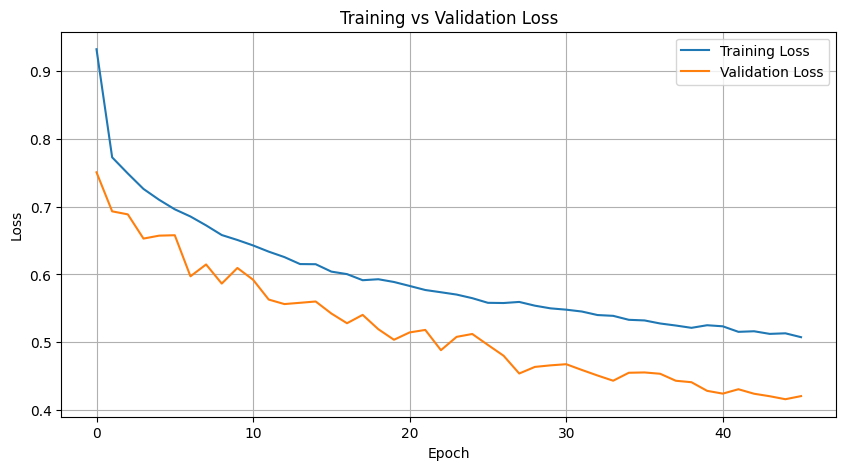

In [ ]:
import json
import matplotlib.pyplot as plt
import re

def extract_data_from_file(filepath):
    epochs = []
    train_losses = []
    val_losses = []

    with open(filepath, 'r') as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith('{'):
            try:
                data = json.loads(line)
                val_losses.append(data["validation_loss_giou"])
                epochs.append(data["epoch"])

                train_losses.append(data["train_loss_giou"])
            except :
              pass


    return epochs, train_losses, val_losses

def plot_losses(epochs, train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    if any(val_losses):
        plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# File path to your log file
# file_path = '/content/drive/MyDrive/test/dior_rs8_lr_05/log.txt' #8heads 0.0005
# file_path = '/content/drive/MyDrive/test/dior_rs/log.txt' #16 heads
file_path = '/content/drive/MyDrive/test/23_04_1/log.txt'

# Extract data
epochs, train_losses, val_losses = extract_data_from_file(file_path)
print(len(epochs))
# Plot the data
plot_losses(epochs, train_losses, val_losses)


In [ ]:
!CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch --nproc_per_node=1 \
--master_port 28888 --use_env /content/drive/MyDrive/CLIP-VG/eval.py --num_workers 2 \
--batch_size 128    --dataset dior_rs      --imsize 224 --max_query_len 77 \
--vl_nheads 16 \
--data_root /content/drive/MyDrive/data-dior \
--split_root /content/drive/MyDrive/unsup_multi_source_msa \
--eval_model /content/drive/MyDrive/unsup_multi_source/referit/best_checkpoint.pth  \
--eval_set val    --output_dir /content/drive/MyDrive/test \
--resume /content/drive/MyDrive/CLIP-VG/test/dior_rs/best_checkpoint.pth;
